# Preprocessing

In [1]:
import torch
from torch.utils.data import Dataset, DataLoader
import numpy as np

import random
from pathlib import Path

import pandas as pd
import matplotlib.pyplot as plt

import optuna
import os, sys

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)


/home/ubnps23/tecHub/AD_intro/advattacks_iitp_summer/a3_env/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


cpu


In [2]:
# changing core directory
dir2 = os.path.abspath('')
dir1 = os.path.dirname(dir2)
if not dir1 in sys.path:
    sys.path.append(dir1)
os.chdir('..')
%ls

attacker_iter_unrolled.pth  notebooks/                  source/
config_examples/            README.md                   surrogate_maxloss.pth
datasets/                   rescnn_classifier_best.pth


In [3]:
from source.training.early_stopping import EarlyStopping
from source.data.power_cons import load_powercons, PowerConsDataset

# from source.training.activation import Activation

from source.classifiers.LSTM_Classifier import LSTMClassifier
from source.classifiers.ResCNN_Classifier import ResCNNClassifier
from source.classifiers.PatchTST_classifier import PatchTSTClassifier
from source.training.train_classifier import train_classifier

In [4]:
SEED = 1000
random.seed(SEED)
os.environ["PYTHONHASHSEED"] = str(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)

torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [5]:
TRAIN_PATH = Path('datasets/PowerCons_TRAIN.tsv')
TEST_PATH = Path('datasets/PowerCons_TEST.tsv')
BATCH_SIZE = 64

# Dataset preparation

In [6]:
X_train, y_train, classes_ = load_powercons(TRAIN_PATH)
X_test, y_test, _ = load_powercons(TEST_PATH)
n_classes = len(classes_)
print('Train shape:', X_train.shape, 'Test shape:', X_test.shape, 'n_classes:', n_classes)

Train shape: (180, 144, 1) Test shape: (180, 144, 1) n_classes: 2


In [7]:
print(X_train.min(), X_train.max(), X_test.min(), X_test.max())

-1.6031435 6.4025993 -1.6804967 5.9844995


In [8]:
train_ds = PowerConsDataset(X_train, y_train)
test_ds = PowerConsDataset(X_test, y_test)
train_dl = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True)
test_dl = DataLoader(test_ds, batch_size=BATCH_SIZE)

counts:
1    90
2    90
Name: 0, dtype: int64
shares:
1    0.5
2    0.5
Name: 0, dtype: float64


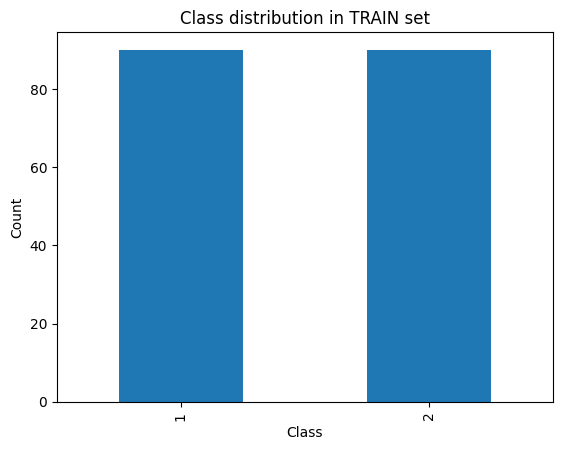

In [9]:
# check data-balance
df = pd.read_csv(TRAIN_PATH, sep='\t', header=None)

label_counts = df.iloc[:, 0].value_counts().sort_index()
print(f'counts:\n{label_counts}')     
print(f'shares:\n{label_counts / len(df)}')


label_counts.plot.bar()
plt.title('Class distribution in TRAIN set')
plt.xlabel('Class')
plt.ylabel('Count')
plt.show()


In [10]:
def seed_worker(worker_id):
    worker_seed = SEED + worker_id
    np.random.seed(worker_seed)
    random.seed(worker_seed)

g = torch.Generator()
g.manual_seed(SEED)
train_dl = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True, num_workers=4, worker_init_fn=seed_worker, generator=g)
test_dl = DataLoader(test_ds, batch_size=BATCH_SIZE, shuffle=False, num_workers=4, worker_init_fn=seed_worker, generator=g)

# Classifiers

In [11]:
clf_LSTM = LSTMClassifier(n_classes, hidden_size=50, num_layers=1)

history, _, _=  train_classifier(
    clf_LSTM,
    train_dl,
    val_loader=test_dl,
    epochs=2,
    lr=1e-3,
    weight_decay=1e-4,
    device=device,
    patience=4,
    verbose_every=1
)

Epoch 01: train_loss=0.6967 acc=0.4611 | val_loss=0.6944 acc=0.5000
Epoch 02: train_loss=0.6932 acc=0.5000 | val_loss=0.6917 acc=0.5000


In [12]:
clf_resCNN = ResCNNClassifier(n_classes=n_classes, x_dim=1).to(device)

history, best_val, best_state = train_classifier(
    clf_resCNN,
    train_loader=train_dl,
    val_loader=test_dl,
    epochs=2,
    lr=1e-3,
    weight_decay=1e-4,
    device=device,
    patience=10,
    verbose_every=1
)

torch.save(best_state, "rescnn_classifier_best.pth")

Epoch 01: train_loss=0.4787 acc=0.7278 | val_loss=0.4689 acc=0.8222
Epoch 02: train_loss=0.3573 acc=0.8389 | val_loss=0.5014 acc=0.7556


In [13]:
loader = train_dl
x, _ = next(iter(loader))
seq_len = x.size(1)
print("Sequence length =", seq_len)

Sequence length = 144


In [14]:
patch_params = dict(
    seq_len=seq_len,
    n_layers=3,
    n_heads=8,
    d_model=512,
    d_ff=2048,
    dropout=0.4,
    attn_dropout=0.0,
    patch_len=40,
    stride=24,
    padding_patch=True,
    revin=True,
    affine=False,
    individual=False,
    subtract_last=False,
    decomposition=False,
    kernel_size=25,
    activation="gelu",
    norm="BatchNorm",
    pre_norm=False,
    res_attention=True,
    store_attn=False,
)

clf_PatchTST = PatchTSTClassifier(
    n_classes=n_classes,
    x_dim=1,
    activation_type="identity",
    patch_kwargs=patch_params
).to(device)

history, best_val, best_wts = train_classifier(
    model=clf_PatchTST,
    train_loader=train_dl,
    val_loader=test_dl,
    epochs=2,
    lr=1e-3,
    weight_decay=1e-4,
    device=device,
    patience=8,
    verbose_every=2
)

Epoch 02: train_loss=2.5705 acc=0.7778 | val_loss=1.8489 acc=0.8667


# Adversarial attacks

In [15]:
LEARNING_TARGET = clf_PatchTST

In [16]:
from source.attacks.iFGSM import FGSMAttack, iFGSMAttack
from source.attacks.PGD import PGDAttack 

from source.attacks.attackLSTM import AttackLSTM
from source.attacks.attackResCNN import AttackCNN
from source.attacks.attackPatchTST import AttackPatchTST 
from source.attacks.iMBA_PatchTST import IterModelAttack

from source.attacks.mba import ModelBasedAttack


from source.training.train_attacker import train_atk_model
from source.training.train_iter_attack import train_attack_iter, prepare_victim_for_input_grad

## LSTM attack

In [17]:
atk_LSTM = AttackLSTM(hidden_dim=128, dropout=0.6, x_dim=1, activation_type='tanh').to(device)
for p in clf_LSTM.parameters():
    p.requires_grad_(False)
# clf_LSTM.eval()

eps_LSTM = 1.371353
train_atk_model(atk_LSTM,
                LEARNING_TARGET,
                train_dl,
                eps=eps_LSTM,
                epochs=1,
                lr=1e-1,
                alpha_l2=6e-4,
                device=device,
                patience=9
)


Epoch 01 | victim‑loss 1.7673 | acc 0.8556


(1.7672858662075466, 0.8555555489328173)

In [18]:
def objective(trial):
    eps = trial.suggest_float("eps",    0.5, 2.0,    log=True)
    lr  = trial.suggest_float("lr",     1e-3, 1e-2,   log=True)
    alpha_l2  = trial.suggest_float("alpha_l2", 1e-5, 1e-1, log=True)
    patience  = trial.suggest_int("patience", 3, 10)
    hidden_dim = trial.suggest_categorical("hidden_dim", [64, 128, 256])
    dropout = trial.suggest_float("dropout", 0.1, 0.6, step=0.1)

    atk_model = AttackLSTM(
        hidden_dim=hidden_dim, x_dim=1,
        activation_type='tanh', dropout=dropout
    )

    val_loss, val_acc = train_atk_model(
        atk_model, clf_LSTM, train_dl,
        eps=eps,  epochs=50, lr=lr, alpha_l2=alpha_l2,
        device=device, patience=patience
    )

    return val_acc

# study = optuna.create_study(direction="minimize", sampler=optuna.samplers.TPESampler(),
#                             pruner=optuna.pruners.MedianPruner(n_warmup_steps=3))

# study.optimize(objective, n_trials=50, timeout=60*60)
# print("BEST PARAMS:", study.best_params)


## ResCNN attack

In [19]:
atk_resCNN = AttackCNN().to(device)
atk_resCNN = AttackCNN(hidden_dim=64, x_dim=1, activation_type='tanh').to(device)

# weights_path = 'weights/surr_resCNNfc_CPU_0.28.pth'

eps_resCNN = 2
train_atk_model(atk_resCNN, LEARNING_TARGET, train_dl,
                eps=eps_resCNN,
                epochs=2, lr=2e-4, alpha_l2=4.5e-05,
                device=device, patience=10, is_debugged=False)


Epoch 01 | victim‑loss 2.7898 | acc 0.7444

Epoch 02 | victim‑loss 5.3874 | acc 0.4056


(5.387413756052653, 0.4055555582046509)

In [20]:
def objective(trial):
    eps = trial.suggest_float("eps",    0.5, 2.0,    log=True)
    lr  = trial.suggest_float("lr",     1e-3, 1e-2,   log=True)
    alpha_l2  = trial.suggest_float("alpha_l2", 1e-5, 1e-1, log=True)
    patience  = trial.suggest_int("patience", 3, 10)
    hidden_dim = trial.suggest_categorical("hidden_dim", [64, 128, 256])

    atk_model = AttackCNN(hidden_dim=hidden_dim, x_dim=1, activation_type='tanh')

    val_loss, val_acc = train_atk_model(
        atk_model, clf_LSTM, train_dl,
        eps=eps,  epochs=50, lr=lr, alpha_l2=alpha_l2,
        device=device, patience=patience
    )

    return val_acc

# study = optuna.create_study(direction="minimize", sampler=optuna.samplers.TPESampler(),
#                             pruner=optuna.pruners.MedianPruner(n_warmup_steps=3))
# study.optimize(objective, n_trials=50, timeout=60*60)
# print("BEST PARAMS:", study.best_params)


## PatchTST Attack

In [21]:
patch_params = dict(
    seq_len=seq_len,
    n_layers=3,
    n_heads=8,
    d_model=512,
    d_ff=2048,
    dropout=0.4,
    attn_dropout=0.0,
    patch_len=28,
    stride=24,
    padding_patch=True,
    revin=True,
    affine=False,
    individual=False,
    subtract_last=False,
    decomposition=False,
    kernel_size=25,
    activation="gelu",
    norm="BatchNorm",
    pre_norm=False,
    res_attention=True,
    store_attn=False,
)

atk_PatchTST = AttackPatchTST(
    hidden_dim=256,
    x_dim=1,
    activation_type="tanh",
    patch_kwargs=patch_params,
)

eps_PatchTST = 1
train_atk_model(atk_PatchTST, clf_PatchTST, train_dl,
                eps=eps_PatchTST,
                epochs=2, lr=2e-4, alpha_l2=1e-4,
                device=device, patience=8, is_debugged=False)


Epoch 01 | victim‑loss 1.7337 | acc 0.8611

Epoch 02 | victim‑loss 1.6657 | acc 0.8889


(1.665745210647583, 0.8888888941870795)

In [22]:
SEQ_LEN  = seq_len
X_DIM    = 1
DEVICE   = device
VICTIM   = LEARNING_TARGET
TRAIN_DL = train_dl

def objective(trial: optuna.Trial):

    # atk params
    eps        = trial.suggest_float("eps",        0.1, 2,    log=True)
    lr         = trial.suggest_float("lr",         1e-4, 1e0,  log=True)
    alpha_l2   = trial.suggest_float("alpha_l2",   1e-5, 1e-2,  log=True)
    patience   = trial.suggest_int  ("patience",   3, 10)

    # architecture
    hidden_dim = trial.suggest_categorical("hidden_dim", [64, 128, 256])

    # main hyperparams
    patch_len  = trial.suggest_int("patch_len", 8, 48, step=4)
    stride_max = patch_len                      # stride не может превышать patch_len
    stride     = trial.suggest_int("stride",    4, stride_max, step=4)
    n_layers   = trial.suggest_int("n_layers",  1, 4)
    d_model    = trial.suggest_categorical("d_model", [256, 512, 768])
    dropout    = trial.suggest_float("dropout", 0.1, 0.6, step=0.1)

    # patch-kwargs
    patch_kwargs = dict(
        seq_len       = SEQ_LEN,
        n_layers      = n_layers,
        n_heads       = 8,
        d_model       = d_model,
        d_ff          = 4 * d_model,
        dropout       = dropout,
        attn_dropout  = 0.0,
        patch_len     = patch_len,
        stride        = stride,
        padding_patch = True,
        revin         = True,
        affine        = False,
        individual    = False,
        subtract_last = False,
        decomposition = False,
        kernel_size   = 25,
        activation    = "gelu",
        norm          = "BatchNorm",
        pre_norm      = False,
        res_attention = True,
        store_attn    = False,
    )

    surrogate = AttackPatchTST(
        hidden_dim     = hidden_dim,
        x_dim          = X_DIM,
        activation_type= "tanh",
        patch_kwargs   = patch_kwargs
    )

    val_loss, val_acc = train_atk_model(
        surrogate, VICTIM, TRAIN_DL,
        eps=eps, epochs=50, lr=lr, alpha_l2=alpha_l2,
        device=DEVICE, patience=patience
    )

    return val_acc


# sampler = optuna.samplers.TPESampler()
# pruner  = optuna.pruners.MedianPruner(n_warmup_steps=3)

# study = optuna.create_study(direction="minimize", sampler=sampler, pruner=pruner)
# study.optimize(objective, n_trials=50, timeout=60*60)

# print("BEST PARAMS:", study.best_params)


## Iter-PatchTST attack

In [23]:


attacker = AttackPatchTST(hidden_dim=256, x_dim=1, activation_type='tanh',
                          patch_kwargs=patch_params).to(device)

target = LEARNING_TARGET
prepare_victim_for_input_grad(target)

disc = None
best = {'eps': 0.4,
         'lr': 1e-4,
         'alpha_l2': 1e-4,
         'steps': 1, 'use_alpha_explicit': False, 
         'proj': 'none', 'proj_equal_eps': True, 'rand_init': False, 'bpda': False, 
         'use_sign': False, 'momentum_mu': 0.9, 'step_normalize': None, 
         'step_noise_std': 0.004, 'victim_eval': True, 'hidden_dim': 128}
best['alpha'] = None

alpha_explicit = None

val_loss, val_acc = train_attack_iter(
    attacker=attacker,
    victim=target,
    loader=train_dl,

    eps=best["eps"],
    steps=best["steps"],
    alpha=alpha_explicit,
    epochs=2,
    lr=best["lr"],
    alpha_l2=best["alpha_l2"],

    lambda_disc=0.0,
    disc=disc,
    device=device,
    patience=8,

    data_clamp=None,
    rand_init=best["rand_init"],
    use_sign=best["use_sign"],
    equal_eps=best["proj_equal_eps"],
    bpda=best["bpda"],
    verbose=True,

    proj=best["proj"],
    proj_equal_eps=best["proj_equal_eps"],
    momentum_mu=best["momentum_mu"],      
    step_normalize=best["step_normalize"],
    step_noise_std=best["step_noise_std"],
    victim_eval=best["victim_eval"],      
    grad_clip=None,                       
)

print(f"[done] val_loss={val_loss:.4f}  |  val_acc(after attack)={val_acc:.4f}")



[Δ] mean ||δ||_2 = 0.760 | mean ||δ||_∞ = 0.067
[Δ] mean ||x||_2 = 11.489 | mean ||x_adv||_2 = 11.338
[Δ] mean ||δ||_2 = 0.888 | mean ||δ||_∞ = 0.078
[Δ] mean ||x||_2 = 10.817 | mean ||x_adv||_2 = 10.841
[Δ] mean ||δ||_2 = 1.067 | mean ||δ||_∞ = 0.093
[Δ] mean ||x||_2 = 11.387 | mean ||x_adv||_2 = 11.413
Epoch 01 | victim-loss 1.6785 | acc 0.8944
[Δ] mean ||δ||_2 = 1.520 | mean ||δ||_∞ = 0.131
[Δ] mean ||x||_2 = 11.185 | mean ||x_adv||_2 = 11.396
[Δ] mean ||δ||_2 = 2.161 | mean ||δ||_∞ = 0.184
[Δ] mean ||x||_2 = 11.302 | mean ||x_adv||_2 = 11.886
[Δ] mean ||δ||_2 = 2.241 | mean ||δ||_∞ = 0.191
[Δ] mean ||x||_2 = 11.163 | mean ||x_adv||_2 = 11.818
Epoch 02 | victim-loss 1.6784 | acc 0.8944
[done] val_loss=1.6784  |  val_acc(after attack)=0.8944


In [25]:
iter_attack = IterModelAttack(
    attacker=attacker, eps=best['eps'], n_iter=best['steps'], alpha=None,
    clamp=None, rand_init=best['rand_init'], use_sign=best['use_sign'],
    equal_eps=best['proj_equal_eps'], bpda=best['bpda'],
    proj=best['proj'], proj_equal_eps=best['proj_equal_eps'],
    data_clamp=None,
    momentum_mu=best['momentum_mu'], step_normalize=None,
    step_noise_std=best['step_noise_std'],
).to(device)

eps_iter = best['eps']


# Сomparison of attacks

In [26]:
from source.estimation.metrics import fooling_rate, efficiency_rate, accuracy_after_attack

In [27]:
eps_FGSM = 1
fgsm_attack  = FGSMAttack(eps_FGSM)
ifgsm_attack = iFGSMAttack(eps=eps_FGSM, n_iter=60)

mba_LSTM = ModelBasedAttack(atk_LSTM, eps_LSTM)
mba_resCNN = ModelBasedAttack(atk_resCNN, eps_resCNN)
mba_PatchTST = ModelBasedAttack(atk_PatchTST, eps_PatchTST)

mba_iter = ModelBasedAttack(iter_attack, eps_iter, is_iter=True)

In [28]:
estimation_dl = test_dl

attacks = {'Unattacked': lambda model, x, y: x,
           'FGSM': fgsm_attack,
           'iFGSM10nonrand02': iFGSMAttack(eps=eps_FGSM, n_iter=10, rand_init=False, momentum=0.2),
           'LSTM': mba_LSTM,
           'resCNN': mba_resCNN,
           'PatchTST': mba_PatchTST,
           'iter': mba_iter}

In [29]:
classifiers = [clf_LSTM, clf_resCNN, clf_PatchTST]

In [33]:
for clf_model in classifiers:
    print('\n'+'='*40)
    print(f'inference target model: {clf_model.__class__.__name__}')
    print('='*40)
    for name, atk in attacks.items():
        fl_rate = fooling_rate(clf_model, estimation_dl, atk, device=device)
        ef_rate = efficiency_rate(clf_model, estimation_dl, atk, device=device)
        acc = accuracy_after_attack(clf_model, estimation_dl, atk, device=device)
        print(f'{name:<12} fooling rate:  {fl_rate:.3f},  efficiency metric:  {ef_rate:.3f},  target accuracy after attack:  {acc:.3f}')


inference target model = LSTMClassifier
Unattacked   fooling rate:  0.000,  efficiency metric:  0.333,  target accuracy after attack:  0.500
FGSM         fooling rate:  0.033,  efficiency metric:  0.364,  target accuracy after attack:  0.467
iFGSM10nonrand02 fooling rate:  0.033,  efficiency metric:  0.364,  target accuracy after attack:  0.467
LSTM         fooling rate:  0.000,  efficiency metric:  0.333,  target accuracy after attack:  0.500
resCNN       fooling rate:  0.000,  efficiency metric:  0.333,  target accuracy after attack:  0.500
PatchTST     fooling rate:  0.000,  efficiency metric:  0.333,  target accuracy after attack:  0.500
iter         fooling rate:  0.000,  efficiency metric:  0.333,  target accuracy after attack:  0.500

inference target model = ResCNNClassifier
Unattacked   fooling rate:  0.000,  efficiency metric:  0.319,  target accuracy after attack:  0.756
FGSM         fooling rate:  0.722,  efficiency metric:  0.935,  target accuracy after attack:  0.033
iFG

## visualization of the attacked data

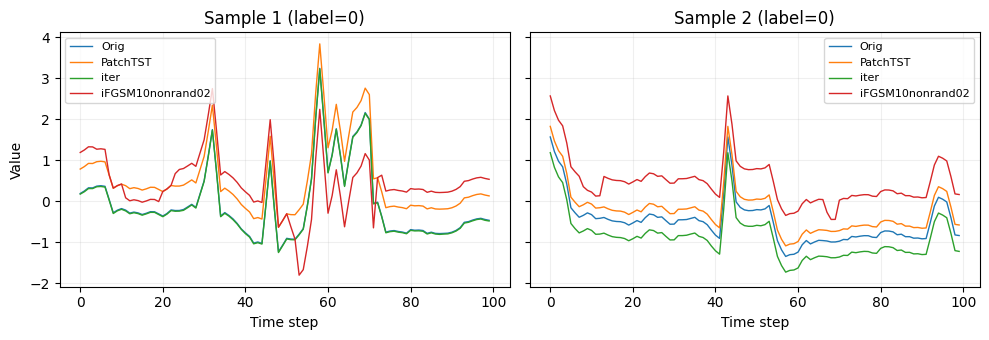

In [40]:
# attacks = {'Unattacked': lambda model, x, y: x,
#            'FGSM': fgsm_attack,
#            'iFGSM10nonrand02': iFGSMAttack(eps=eps_FGSM, n_iter=10, rand_init=False, momentum=0.2),
#            'LSTM': mba_LSTM,
#            'resCNN': mba_resCNN,
#            'PatchTST': mba_PatchTST,
#            'iter': mba_iter}


N_EXAMPLES = 2
FILTER = ['PatchTST',
          'iter',
          'iFGSM10nonrand02']

van_iFGSM = iFGSMAttack(eps=eps_FGSM, n_iter=50, rand_init=False, momentum=0.0)
van_FGSM = fgsm_attack
van_PGD = None


atk_f_list = [attacks[name] for name in FILTER]


chosen = []
for xb, yb in test_dl:
    for i in range(xb.size(0)):
        chosen.append((xb[i], yb[i]))
    if len(chosen) >= 50:
        break

examples = random.sample(chosen, N_EXAMPLES)

fig, axes = plt.subplots(
    1, N_EXAMPLES,
    figsize=(5 * N_EXAMPLES, 3.5),
    sharey=True
)
if N_EXAMPLES == 1:
    axes = [axes]

for col, (x_orig, y_lbl) in enumerate(examples):
    ax = axes[col]
    x_orig = x_orig.to(device).unsqueeze(0)
    y_lbl_tensor = torch.tensor([y_lbl], device=device)

    x_np = x_orig.squeeze().detach().cpu().numpy()
    ax.plot(x_np[:100], label='Orig', linewidth=1)

    x_adv_np_dict = dict()
    for name in FILTER:
        dummy_model = clf_LSTM
        mba_attack = attacks[name]
        x_adv = mba_attack(dummy_model, x_orig, y_lbl_tensor)
        x_adv_np_dict[name] = (x_adv.squeeze().detach().cpu().numpy())

    for name in FILTER:
        ax.plot(x_adv_np_dict[name][:100], label=name, linewidth=1)

    ax.set_title(f'Sample {col+1} (label={int(y_lbl)})')
    ax.set_xlabel('Time step')
    if col == 0:
        ax.set_ylabel('Value')
    ax.grid(True, alpha=0.2)
    ax.legend(fontsize=8)

plt.tight_layout()
plt.show()
